In [2]:
library(phyloseq)
library(ggplot2)
library(vegan)
library(readr)
library(data.table)
library(dplyr)
library(stats)
library(ggpubr)
library(dunn.test)
library(viridis)

In [3]:
cmp_nt = readRDS("/home/holutz/projects/CMP_redo/RDSfiles/cmp_nt.rds")
cmp_t = readRDS("/home/holutz/projects/CMP_redo/RDSfiles/cmp_t.rds")
#cmp_t.mdf = readRDS("/home/holutz/projects/CMP/psfiles/cmp_t.mdf.rds")

In [5]:
#cmp_t.mdf = psmelt(cmp_t)
cmp_t.mdf = readRDS("/home/holutz/projects/CMP_redo/RDSfiles/cmp_t.mdf.rds")

In [46]:
cmp.df = data.frame(sample_data(cmp_nt))
head(cmp.df$Host_taxon)
head(cmp.df$SampleType)
#cmp.df %>% group_by(SampleType) %>% summarize(count = n())

[1] Metasepia_pfefferi Euprymna_berryi    Euprymna_berryi    Sepia_bandensis   
[5] Euprymna_berryi    Euprymna_berryi   
9 Levels: Doryteuthis_pealeii Euprymna_berryi ... Wonderpus_photogenicus

[1] Esophagus   Gill        Esophagus   Esophagus   Light organ Gill       
19 Levels: Acc. Nid. Gland Cecal gland Cecum Cecum Intestine Crop ... Whole Animal

In [6]:
eber = subset(cmp_t.mdf, Host_taxon=="Euprymna_berryi")
esco = subset(cmp_t.mdf, Host_taxon=="Euprymna_scolopes")
mpfe = subset(cmp_t.mdf, Host_taxon=="Metasepia_pfefferi")
negative = subset(cmp_t.mdf, Host_taxon=="Negative")
bmac = subset(cmp_t.mdf, Host_taxon=="Octopus_bimaculoides")
sban = subset(cmp_t.mdf, Host_taxon=="Sepia_bandensis")
soff = subset(cmp_t.mdf, Host_taxon=="Sepia_officinalis")
wpho = subset(cmp_t.mdf, Host_taxon=="Wonderpus_photogenicus")

In [23]:
eso = subset(cmp_t.mdf, SampleType=="Esophagus")

In [49]:
colnames(eber)
head(eber$Treatment)

[1] "OTU"                           "Sample"                       
 [3] "Abundance"                     "X.SampleID"                   
 [5] "BarcodeSequence"               "LinkerPrimerSequence"         
 [7] "well_id"                       "extraction_plate"             
 [9] "primer_plate"                  "center_name"                  
[11] "platform"                      "instrument_model"             
[13] "flowcell_type"                 "sequencing_method"            
[15] "center_project_name"           "run_center"                   
[17] "run_date"                      "experiment_design_description"
[19] "library_construction_protocol" "target_gene"                  
[21] "target_subfragment"            "pcr_primers"                  
[23] "qiita_id"                      "run_prefix"                   
[25] "Plate"                         "Well"                         
[27] "sample_Sample"                 "Host_Genus"                   
[29] "Host_species"                  "Host_taxon"                   
[31] "Common_name"                   "SystemType"                   
[33] "SampleType"                    "Storage"                      
[35] "Sex"                           "Mass"                         
[37] "DD"                            "Treatment"                    
[39] "Notes"                         "Description"                  
[41] "Rank1"                         "Rank2"                        
[43] "Rank3"                         "Rank4"                        
[45] "Rank5"                         "Rank6"                        
[47] "Rank7"

[1] Conditioned treatment Open treatment        <NA>                 
[4] Conditioned treatment Conditioned treatment Conditioned treatment
Levels: Conditioned treatment Full closed treatment Open treatment

In [10]:
N = 20

topN = eber %>%
    group_by(Rank2) %>%
    summarize(Abundance = sum(Abundance)) %>%
    group_by(Rank2) %>%
    summarize(m = mean(Abundance)) %>%
    top_n(N) %>%
    arrange(desc(m)) %>%
    magrittr::extract2("Rank2")

mdfall.other = eber %>%
    mutate(Rank2.other = ifelse(Rank2 %in% topN, as.character(Rank2), "Other")) %>%
    group_by(SampleType,Treatment, Sample, Rank2.other) %>%
    summarize(Abundance = sum(Abundance)) %>%
    arrange(Abundance)

mdfall.summary = mdfall.other %>%
    group_by(Treatment, SampleType, Rank2.other) %>%
    summarise(avg = mean(Abundance), 
              sd = sd(Abundance), 
              sem = sd/sqrt(length(Abundance)),
              abundance = round(avg*100,2)) %>%
    arrange(Treatment)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

Selecting by m

`summarise()` regrouping output by 'SampleType', 'Treatment', 'Sample' (override with `.groups` argument)

`summarise()` regrouping output by 'Treatment', 'SampleType' (override with `.groups` argument)



In [11]:
head(mdfall.other)

SampleType,Treatment,Sample,Rank2.other,Abundance
<fct>,<fct>,<chr>,<chr>,<dbl>
Acc. Nid. Gland,Open treatment,EBER.016.ANG,Other,0
Acc. Nid. Gland,Open treatment,EBER.016.ANG,p__Acidobacteriota,0
Acc. Nid. Gland,Open treatment,EBER.016.ANG,p__Bdellovibrionota,0
Acc. Nid. Gland,Open treatment,EBER.016.ANG,p__Campilobacterota,0
Acc. Nid. Gland,Open treatment,EBER.016.ANG,p__Chloroflexi,0
Acc. Nid. Gland,Open treatment,EBER.016.ANG,p__Crenarchaeota,0


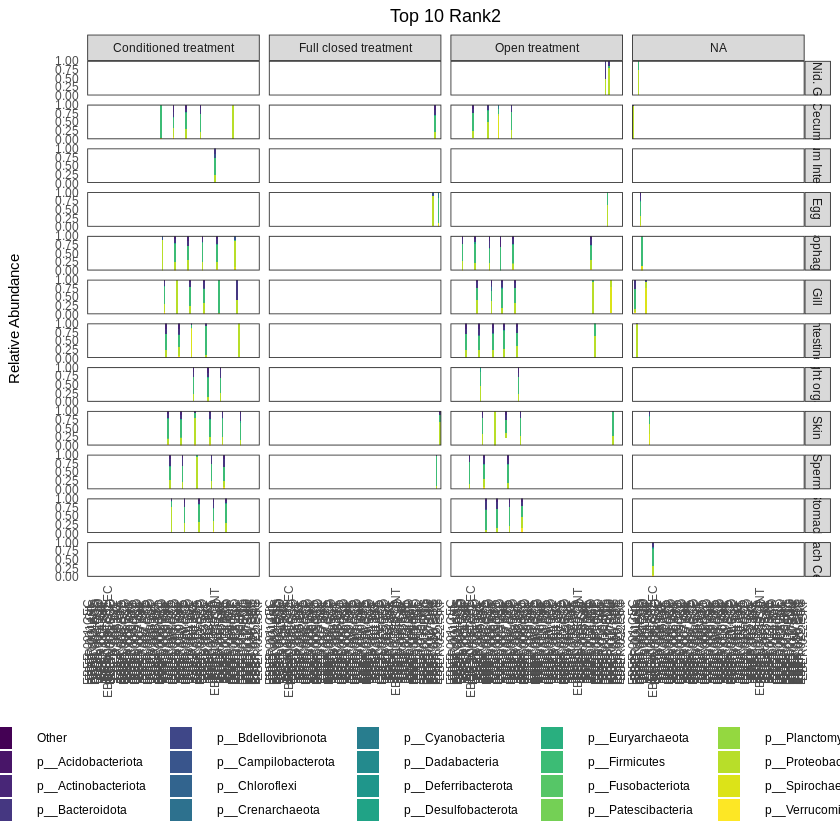

In [13]:
p = ggplot(mdfall.other[order(mdfall.other$Rank2.other),], aes(x=Sample, y = Abundance, fill = Rank2.other))
                        
p = p + #facet_wrap(~Host_taxon, shrink = TRUE, scales = "free_x") +
    ylab("Relative Abundance")  +
    geom_bar(stat="identity") +
    scale_fill_viridis(option="viridis", discrete=TRUE, direction=1) +
    scale_y_continuous(expand = c(0,0))

p = p + guides(fill = guide_legend(title = "Rank2", nrow = 4, keywidth = 1, keyheight = 1))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=9, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              axis.text.x=element_text(angle=90,vjust=0.4),
              #legend.key.size = unit(.25, "mm"),
              legend.spacing.x = unit(.2,"in"),
              axis.title.x=element_blank())

p = p + theme(legend.position="bottom") 

p = p + ggtitle("Top 10 Rank2") + theme(plot.title = element_text(hjust = 0.5))

p = p + facet_grid(SampleType~Treatment)

p

#png('/home/holutz/projects/CMP/temp.png', width=25, height=12, units='in', res=500)
#plot(p)
#dev.off()

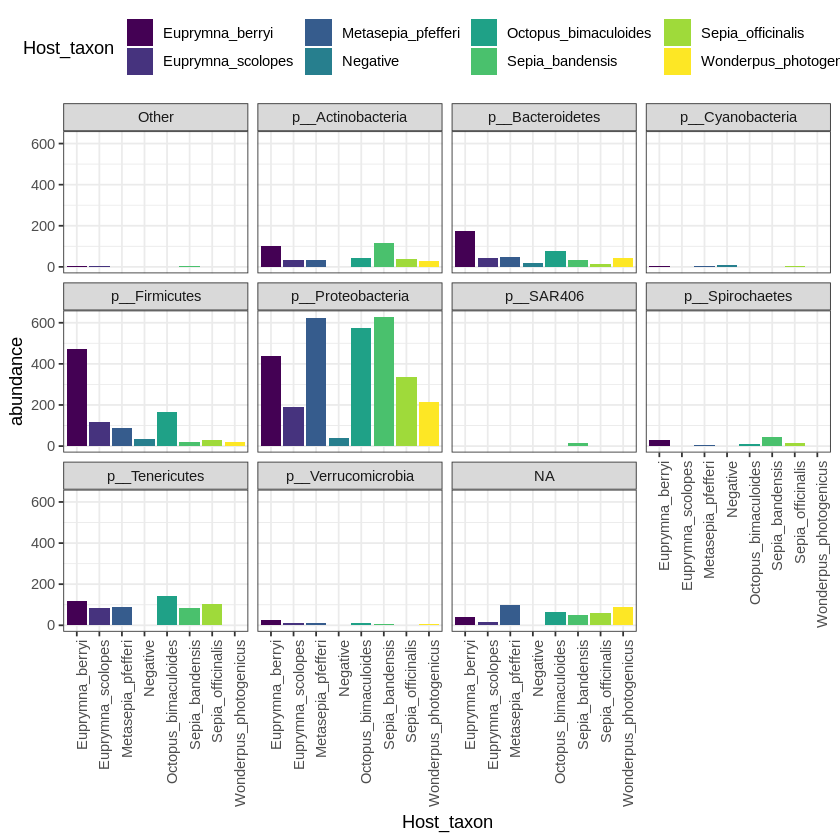

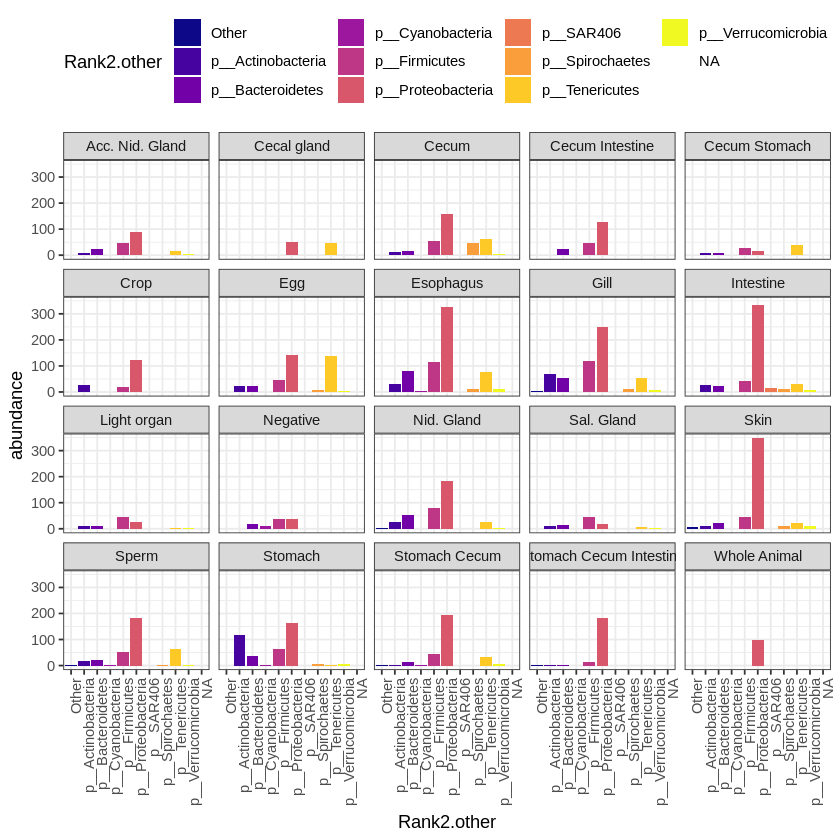

In [67]:
p = ggplot(mdfall.summary, aes(x=Host_taxon, y=abundance, fill=Host_taxon)) +
  geom_bar(stat="identity") +
  theme_bw() +
  theme(legend.position="top",
          axis.text.x = element_text(angle = 90,hjust=1)) +
  scale_fill_viridis(option="viridis", discrete=TRUE, direction=1)
p = p + facet_wrap(~Rank2.other)
p

p2 = ggplot(mdfall.summary, aes(x=Rank2.other, y=abundance, fill=Rank2.other)) +
  geom_bar(stat="identity") +
  theme_bw() + 
  theme(legend.position="top",
          axis.text.x = element_text(angle = 90,hjust=1)) +
  scale_fill_viridis(option="plasma", discrete=TRUE, direction=1)
p2 = p2 + facet_wrap(~SampleType)
p2

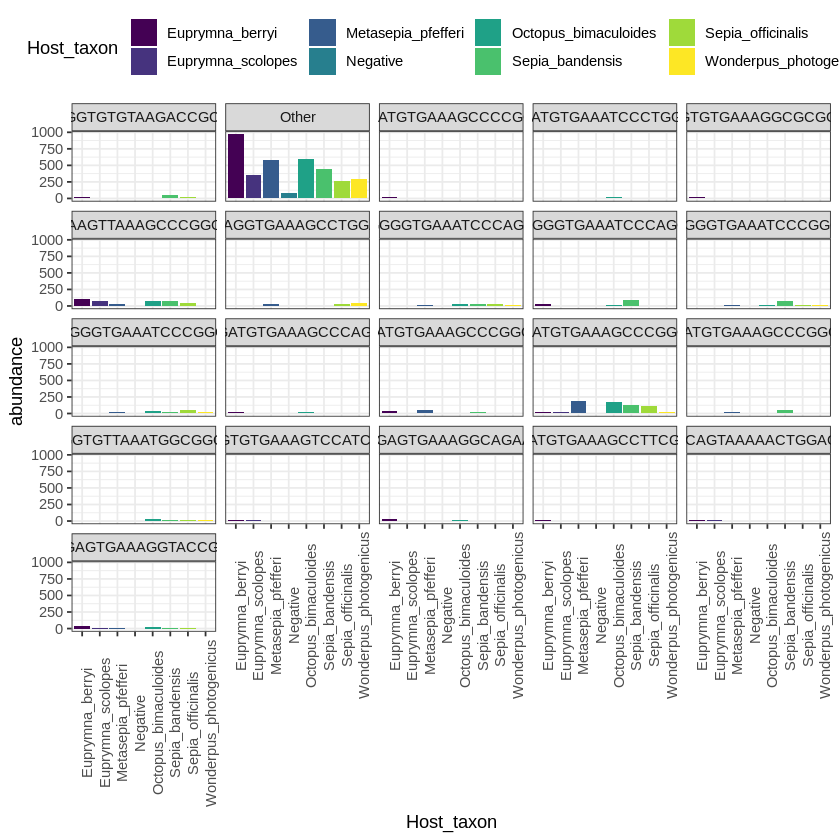

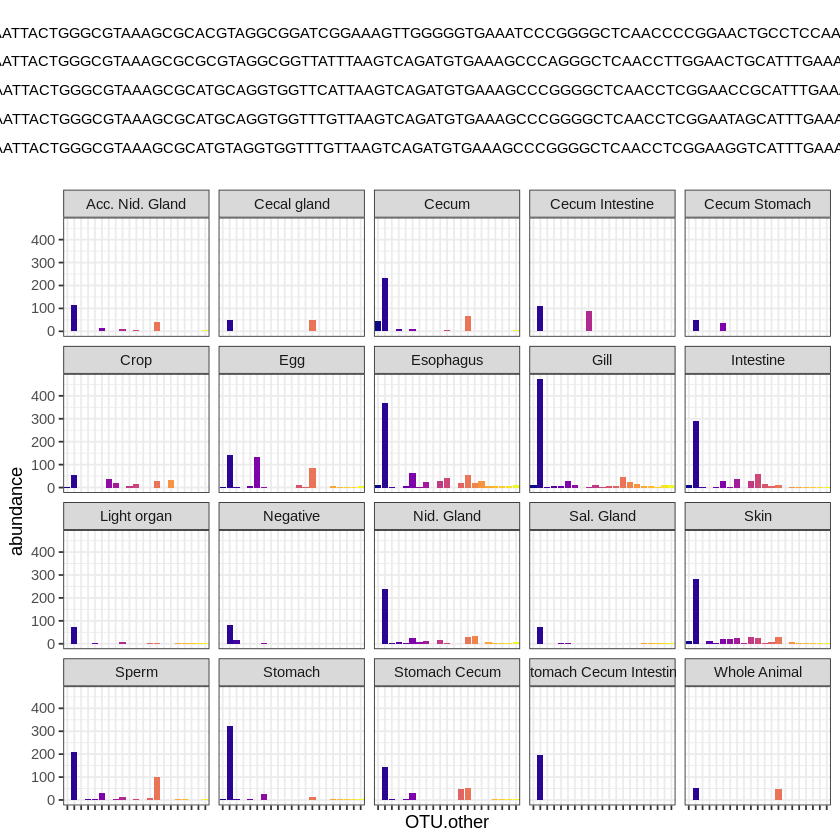

In [78]:
p = ggplot(mdfall.summary, aes(x=Host_taxon, y=abundance, fill=Host_taxon)) +
  geom_bar(stat="identity") +
  theme_bw() +
  theme(legend.position="top",
          axis.text.x = element_text(angle = 90)) +
  scale_fill_viridis(option="viridis", discrete=TRUE, direction=1)
p = p + facet_wrap(~OTU.other)
p

p2 = ggplot(mdfall.summary, aes(x=OTU.other, y=abundance, fill=OTU.other)) +
  geom_bar(stat="identity") +
  theme_bw() + 
  theme(legend.position="top",
        axis.text.x = element_blank()) +  
        #axis.text.x = element_text(angle = 90)) +
  scale_fill_viridis(option="plasma", discrete=TRUE, direction=1)
p2 = p2 + facet_wrap(~SampleType)
p2

In [86]:
head(mdfall.summary)
head(tax)

Host_taxon,SampleType,OTU.other,avg,sd,sem,abundance
<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Euprymna_berryi,Acc. Nid. Gland,CACGTATGGGGCGAGCGTTGTTCGGAATTATTGGGCGTAAAGGGCACGCAGGCGGACTGGAAAGTCTGGTGTGTAAGACCGCAGCTTAACTGCGGAAACGCATTAGAAACTAACAGTCTAGAGTTCAAGAAGGGCAACTGGAATTCCTGG,0.0010083917,0.0008149465,0.0002716488,0.10
Euprymna_berryi,Cecum,CACGTATGGGGCGAGCGTTGTTCGGAATTATTGGGCGTAAAGGGCACGCAGGCGGACTGGAAAGTCTGGTGTGTAAGACCGCAGCTTAACTGCGGAAACGCATTAGAAACTAACAGTCTAGAGTTCAAGAAGGGCAACTGGAATTCCTGG,0.0594374576,0.1633843832,0.0396265335,5.94
Euprymna_berryi,Cecum Intestine,CACGTATGGGGCGAGCGTTGTTCGGAATTATTGGGCGTAAAGGGCACGCAGGCGGACTGGAAAGTCTGGTGTGTAAGACCGCAGCTTAACTGCGGAAACGCATTAGAAACTAACAGTCTAGAGTTCAAGAAGGGCAACTGGAATTCCTGG,0.0011273957,NA,NA,0.11
Euprymna_berryi,Cecum Stomach,CACGTATGGGGCGAGCGTTGTTCGGAATTATTGGGCGTAAAGGGCACGCAGGCGGACTGGAAAGTCTGGTGTGTAAGACCGCAGCTTAACTGCGGAAACGCATTAGAAACTAACAGTCTAGAGTTCAAGAAGGGCAACTGGAATTCCTGG,0.0003823427,NA,NA,0.04
Euprymna_berryi,Egg,CACGTATGGGGCGAGCGTTGTTCGGAATTATTGGGCGTAAAGGGCACGCAGGCGGACTGGAAAGTCTGGTGTGTAAGACCGCAGCTTAACTGCGGAAACGCATTAGAAACTAACAGTCTAGAGTTCAAGAAGGGCAACTGGAATTCCTGG,0.0139252427,0.0382909032,0.0135378787,1.39
Euprymna_berryi,Esophagus,CACGTATGGGGCGAGCGTTGTTCGGAATTATTGGGCGTAAAGGGCACGCAGGCGGACTGGAAAGTCTGGTGTGTAAGACCGCAGCTTAACTGCGGAAACGCATTAGAAACTAACAGTCTAGAGTTCAAGAAGGGCAACTGGAATTCCTGG,0.0125758696,0.0354026524,0.0085864044,1.26


,OTU.other,Rank1,Rank2,Rank3,Rank4,Rank5,Rank6,Rank7
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,TACGAAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCGTTAAGTTGGACGTGAAAGCCCCGGGCTCAACCTGGGAACTGCATCCAAAACTGGCGAGCTAGAGTACGGTAGAGGGTGGTGGAATTTCCTG,k__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Pseudomonadaceae,g__Pseudomonas,s__
2,TACGAAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCGTTGAGTTGGATGTGAAAGCCCCGGGCTCAACCTGGGAACTGCATCCAAAACTGGCGAGCTAGAGTACGGTAGAGGGTGGTGGAATTTCCTG,k__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Pseudomonadaceae,g__,s__
3,TACGAAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCGTTAAGTTGGATGTGAAAGCCCCGGGCTCAACCTGGGAACTGCATCCAAAACTGGCGAGCTAGAGTACGGTAGAGGGTGGTGGGATTTCCTG,k__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Pseudomonadaceae,g__Pseudomonas,NA
4,TACGAAGGGTGTAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCGTTAAGTTGGATGTGAAAGCCCCGGGCTCAACCTGGGAACTGCATCCAAAACTGGCGAGCTAGAGTACGGTAGAGGGTGGTGGAATTTCCTG,k__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Pseudomonadaceae,g__Pseudomonas,NA
5,TACGAAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCGTTAAATTGGATGTGAAAGCCCCGGGCTCAACCTGGGAACTGCATCCAAAACTGGCGAGCTAGAGTACGGTAGAGGGTGGTGGAATTTCCTG,k__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Pseudomonadaceae,g__,s__
6,TACGAAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCGTTAAGTTGGATGTGAAAGCCCCGGGCTCAACCTGGGAACTGCATCCAAAACTGGCGAGCTAGAGTACGGTAGAGGGTGGTGGAGTTTCCTG,k__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Pseudomonadaceae,g__,s__


In [87]:
new = left_join(mdfall.summary,tax)
write.csv(new, "/home/holutz/projects/CMP/cmp.mdfsummary.rank_OTU.csv")

Joining, by = "OTU.other"

Warning message:
“Column `OTU.other` joining character vector and factor, coercing into character vector”
